# Task 3

# Imports

In [1]:
import numpy as np
import pandas as pd
from joblib import dump, load
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'figure.figsize': (8,6)})

## Part 1:

Recall as a final goal of this project. We want to build and deploy ensemble machine learning models in the cloud, where features are outputs of different climate models and the target is the actual rainfall observation. In this milestone, you'll actually build these ensemble machine learning models in the cloud.  

**Your tasks:**

1. Read the data CSV from your s3 bucket. 
2. Drop rows with nans. 
3. Split the data into train (80%) and test (20%) portions with `random_state=123`. 
4. Carry out EDA of your choice on the train split. 
5. Train ensemble machine learning model using `RandomForestRegressor` and evaluate with metric of your choice (e.g., `RMSE`) by considering `Observed` as the target column. 
6. Discuss your results. Are you getting better results with ensemble models compared to the individual climate models? 

> Recall that individual columns in the data are predictions of different climate models. 

In [2]:
## Depending on the permissions that you provided to your bucket you might need to provide your aws credentials
## to read from the bucket, if so provide with your credentials and pass as storage_options=aws_credentials
# aws_credentials = {"key": "","secret": "","token":""}
df = pd.read_csv("s3://mds-s3-9/output/ml_data_SYD.csv", index_col=0, parse_dates=True)

In [3]:
## Use your ML skills to get from step 1 to step 6

### 1. EDA

In [4]:
df.shape

(46020, 26)

In [5]:
df.columns

Index(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-ESM-1-1-LR', 'BCC-CSM2-MR',
       'BCC-ESM1', 'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'CanESM5',
       'EC-Earth3-Veg-LR', 'FGOALS-g3', 'GFDL-CM4', 'INM-CM4-8', 'INM-CM5-0',
       'KIOST-ESM', 'MIROC6', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR',
       'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM',
       'SAM0-UNICON', 'TaiESM1', 'observed_rainfall'],
      dtype='object')

As can be seen from output of two cells above, here we deal with relatively small dataframe for 
rainfall limited to Sydney area only, where we have 25 features and one target variable `observed_rainfall`

#### Check for missing values:

In [6]:
dfna = df[df.isnull().any(axis=1)]
dfna.shape

(0, 26)

This indicates that in our dataframe there are no missing values. Therefore we do not need to take any actions for either dropping or imputing missing values. 

#### Memory reduction techniques

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 46020 entries, 1889-01-01 to 2014-12-31
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ACCESS-CM2         46020 non-null  float64
 1   ACCESS-ESM1-5      46020 non-null  float64
 2   AWI-ESM-1-1-LR     46020 non-null  float64
 3   BCC-CSM2-MR        46020 non-null  float64
 4   BCC-ESM1           46020 non-null  float64
 5   CMCC-CM2-HR4       46020 non-null  float64
 6   CMCC-CM2-SR5       46020 non-null  float64
 7   CMCC-ESM2          46020 non-null  float64
 8   CanESM5            46020 non-null  float64
 9   EC-Earth3-Veg-LR   46020 non-null  float64
 10  FGOALS-g3          46020 non-null  float64
 11  GFDL-CM4           46020 non-null  float64
 12  INM-CM4-8          46020 non-null  float64
 13  INM-CM5-0          46020 non-null  float64
 14  KIOST-ESM          46020 non-null  float64
 15  MIROC6             46020 non-null  float64
 16  MPI-E

As can be seen from output above, data is stored in not optimal way in `numpy.float64` format. However, dataframe is too small, requiring less than 10 MB of memory, therefore we will not apply any memory optimization techniques. 

#### Splitting data on train and test datasets

In [8]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=525)

In [9]:
train_df.shape

(36816, 26)

In [10]:
X_train = train_df.drop('observed_rainfall', axis=1)
X_test = test_df.drop('observed_rainfall', axis=1)
y_train = train_df['observed_rainfall']
y_test = test_df['observed_rainfall']

#### Visualization of data

In [11]:
cols = X_train.columns
melt_X_train = (X_train.reset_index()
                        .melt(id_vars=['time'], 
                              value_vars=cols, 
                              var_name='model',
                              value_name='rain')
               )
melt_X_train['log_rain'] = np.log1p(melt_X_train['rain'])

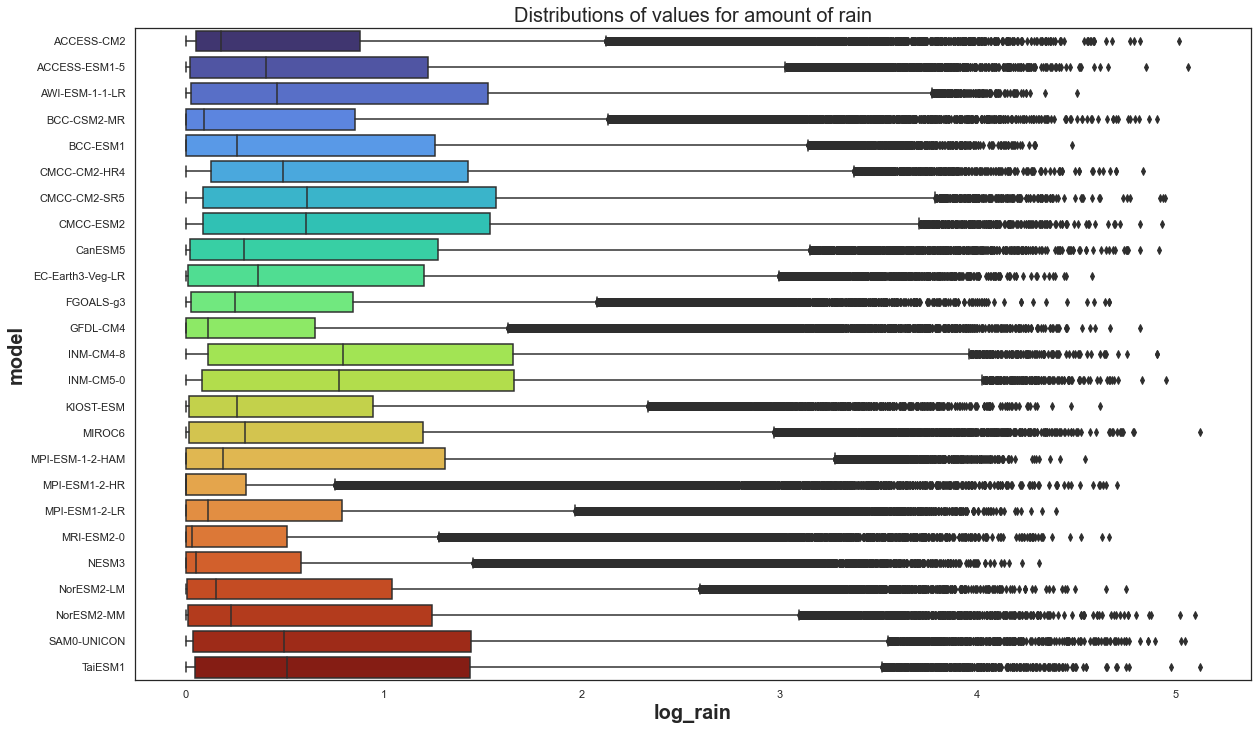

In [12]:
sns.set(rc={'figure.figsize':(20,12),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white") 
sns.boxplot(data = melt_X_train, 
            x="log_rain", 
            y="model", 
            palette='turbo').set_title('Distributions of values for amount of rain'); 

As can be seen from the plot above, our data has a logarithmic behaviour with a wide range of outcomes. Therefore for modeling we will use log transformed features

### 2. Modeling

After conducting mini-grid search was revealed very small difference between RMSE scores for `n_estimators` in the range from 3 to 20 and for `max_depth` in the range of 2 to 20. Therefore for final comparison was selected some reasonable values for those hyperparameters: `n_estimators=10` and `max_depth=10`

#### Simple modeling without feature engineering

In [13]:
rfr_simple = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=525)
rfr_simple.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=10, random_state=525)

In [14]:
print(f"Train RMSE: {mean_squared_error(y_train, rfr_simple.predict(X_train), squared=False):.2f}")
print(f"Test RMSE: {mean_squared_error(y_test, rfr_simple.predict(X_test), squared=False):.2f}")

Train RMSE: 7.47
Test RMSE: 8.50


#### Modeling with logarithmic transformation

In [15]:
X_train_log = X_train.apply(lambda x: np.log1p(x))
X_test_log = X_test.apply(lambda x: np.log1p(x))

In [16]:
rfr_log = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=525)
rfr_log.fit(X_train_log, y_train)

RandomForestRegressor(max_depth=10, n_estimators=10, random_state=525)

In [17]:
print(f"Train RMSE: {mean_squared_error(y_train, rfr_log.predict(X_train_log), squared=False):.2f}")
print(f"Test RMSE: {mean_squared_error(y_test, rfr_log.predict(X_test_log), squared=False):.2f}")

Train RMSE: 7.47
Test RMSE: 8.50


As can be seen from results above, we do not observe any improvements with using log transformed features, therefore we will proceed further without logarithmic transformations

#### Comparing results from individual models with ensemble of models

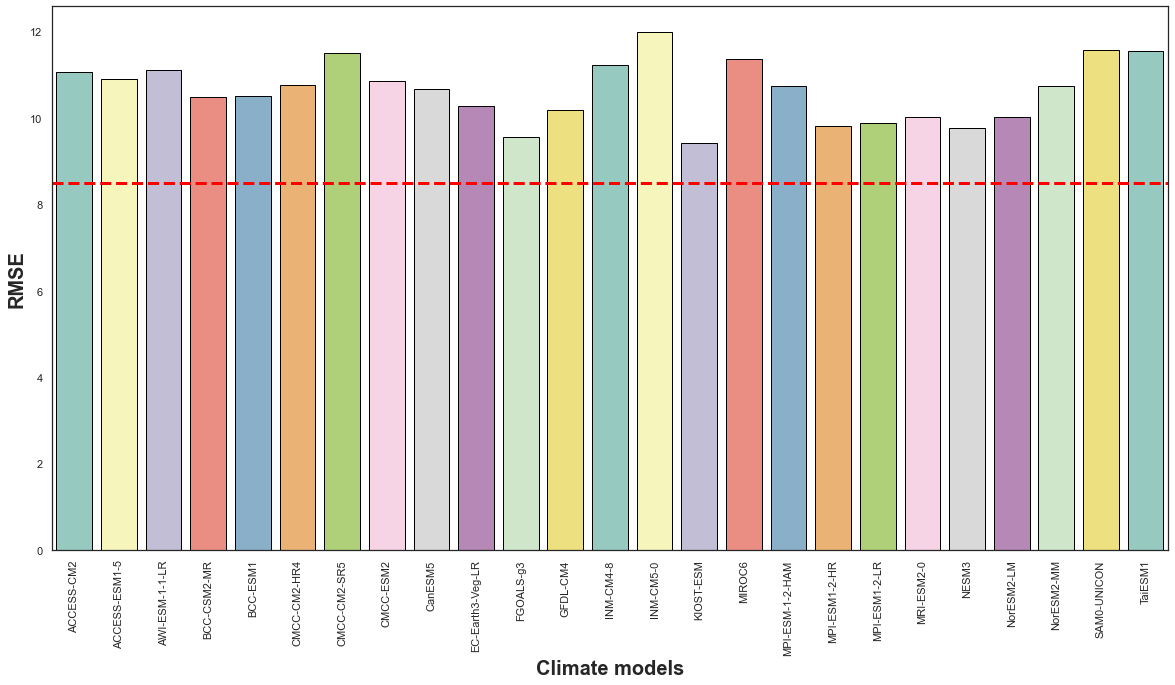

In [18]:
ensembled_test_rmse = mean_squared_error(y_test, rfr_simple.predict(X_test), squared=False)
indiv_results = pd.DataFrame(columns = ['model', 'RMSE'])
for model in X_test.columns:
    model_df = pd.DataFrame([[model, mean_squared_error(y_test, X_test[model], squared=False)]], 
                            columns = ['model', 'RMSE'])
    indiv_results = pd.concat([indiv_results, model_df])
    
sns.set(rc={'figure.figsize':(20,10),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white") 
ax = sns.barplot(x=indiv_results["model"].unique(), 
                 y=indiv_results['RMSE'], 
                 palette='Set3', 
                 ec='black')
ax.set_xlabel('Climate models') 
ax.set_ylabel('RMSE')
ax.axhline(ensembled_test_rmse, ls='--', c = 'red', lw=3)
plt.xticks(rotation=90);

As can be seen from the plot above, we are getting better results with ensemble models compared to any of individual climate models.

## Part 2:

### Preparation for deploying model next week

***NOTE: Complete task 4 from the milestone3 before coming here***

We’ve found the best hyperparameter settings with MLlib (from the task 4 from milestone3), here we then use the same hyperparameters to train a scikit-learn model. 

In [19]:
rfr_optimized = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=525)
rfr_optimized.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=525)

In [20]:
print(f"Train RMSE: {mean_squared_error(y_train, rfr_optimized.predict(X_train), squared=False):.2f}")
print(f" Test RMSE: {mean_squared_error(y_test, rfr_optimized.predict(X_test), squared=False):.2f}")

Train RMSE: 7.93
 Test RMSE: 8.44


In [21]:
# ready to deploy
dump(model, "model.joblib")

['model.joblib']

***Upload model.joblib to s3 under output folder. You choose how you want to upload it (using CLI, SDK, or web console).***